This notebook presents the procedure to get the best similarity function and its corresponding threshold-value to filter the synthetic candidates by structural properties, for the AZKAG dataset. The threshold is obtained by training the sign classifier. For 5 vertex-similarity functions, we report the **score distributions**, the **AUC** value, and **other statistics**: the number of resouces, the requester distributions for resources, and number of examples (for positives and negatives).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
from collections import Counter
import pickle
import math
import random
import copy
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

from src import acgraph as acg
from src import bcloader as bcl
from src import utils as ut
from src import bcgraph as bcg
from efficient_apriori import apriori

### Load access control graph

In [2]:
rel_attnames = [
#'MGR_ID',
#'ROLE_ROLLUP_1',
'ROLE_ROLLUP_2',
'ROLE_DEPTNAME',
'ROLE_TITLE',
'ROLE_FAMILY_DESC',
'ROLE_FAMILY']
gur = acg.load_azkag_graph(rel_attnames=rel_attnames, isWeighted=True)
print('---Control Access Graph---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))

gur_usrlabels,gur_reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(gur_usrlabels))
print('Num resources:', len(gur_reslabels))
print()

gur = acg.get_largestcc(gur)
print('---Largest Connected Component---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))
usrlabels,reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(usrlabels))
print('Num resources:', len(reslabels))

---Control Access Graph---
Total edges: 30872
Total vertices: 16524
Num users: 9298
Num resources: 7226

---Largest Connected Component---
Total edges: 30425
Total vertices: 15773
Num users: 8933
Num resources: 6840


### Useful functions for creating training set

In [3]:
def get_negative_entries(gur):
    df_emp_access = pd.read_csv('data/train.csv')
    
    attnames_list = list(df_emp_access.columns)[2:]

    #---Group by the column header: attvalues, residx, resolution---
    dfgb_temp = df_emp_access.groupby(attnames_list + ['RESOURCE','ACTION'])
    df_temp = dfgb_temp.size().to_frame(name = 'count').reset_index()
    df_temp = df_temp.drop('count', axis=1)

    #---Add user indexes---
    dfgb_temp = df_temp.groupby(attnames_list)

    dfs_list = []
    usridx = 0
    for _,df in dfgb_temp:
        k = df.shape[0]
        df.insert(loc=0, column='USR_ID', value=[usridx for _ in range(k)])
        dfs_list.append(df)
        usridx += 1
    df_temp = pd.concat(dfs_list)

    df_entries = df_temp[['USR_ID', 'RESOURCE', 'ACTION']]

    df_neg_entries = df_entries[df_entries['ACTION']==0]

    dfgb_neg = df_neg_entries.groupby(['USR_ID','RESOURCE'])
    df_temp_neg = dfgb_neg.size().to_frame(name = 'COUNT').reset_index()
    usrid_to_resid_neg = df_temp_neg[['USR_ID','RESOURCE']].values.tolist()
    
    #Map ids to indexes in the graph
    usrid_to_vidx = dict()
    resid_to_vidx = dict()
    for v in gur.vs:
        if v['type'] == False:
            usrid = int(v['name'][6:])
            usrid_to_vidx[usrid] = v.index
        else:
            resid = int(v['name'][6:])
            resid_to_vidx[resid] = v.index
    
    usrvidx_resvidx_tups_neg = list()
    for tup in usrid_to_resid_neg:
        usrid = tup[0]
        resid = tup[1]
        if usrid in usrid_to_vidx and resid in resid_to_vidx:
            usrvidx_resvidx_tups_neg.append((usrid_to_vidx[usrid], resid_to_vidx[resid]))
            
    return usrvidx_resvidx_tups_neg


def get_positive_entries(gur, numentries, sd):
    random.seed(sd)
    usrvidx_resvidx_tups_pos = []

    es_sampled = random.sample(sorted(gur.es),numentries)
    for e in es_sampled:
        usrvidx = e.source
        resvidx = e.target
        usrvidx_resvidx_tups_pos.append((usrvidx, resvidx))
        
    gur2 = copy.deepcopy(gur)
    gur2.delete_edges(es_sampled)
    
    return usrvidx_resvidx_tups_pos, gur2
    
    
def get_non_entries(gur, numentries, sd):
    edges_tuples = []
    for e in gur.es:
        edges_tuples.append((e.source,e.target))

    usrvidxs = []
    resvidxs = []
    for v in gur.vs:
        if v['type']:
            resvidxs.append(v.index)
        else:
            usrvidxs.append(v.index)

    random.seed = sd
    usrvidxs_random = random.choices(usrvidxs,k=10*numentries)
    resvidxs_random = random.choices(resvidxs,k=10*numentries)

    i = 0
    j = 0
    usrvidx_resvidx_tups_non = []
    while i < numentries:
        tup = (usrvidxs_random[j], resvidxs_random[j])
        if not tup in edges_tuples: 
            usrvidx_resvidx_tups_non.append(tup)
            i += 1
        j += 1
        
    return usrvidx_resvidx_tups_non
  

In [4]:
def res_requesters_distrib(usrvidx_to_resvidx):
    resvidxset = set()
    for tup in usrvidx_to_resvidx:
        resvidxset.add(tup[1])
    num_requesters = []
    for resvidx in list(resvidxset):
        num_requesters.append(len(gur.neighbors(resvidx)))

    num_requesters_to_freq = dict(Counter(num_requesters))
    num_requesters_to_freq = dict(sorted(num_requesters_to_freq.items(), key=lambda item: item[1]))

    plt.plot(num_requesters_to_freq.keys(), num_requesters_to_freq.values(), '.')
    plt.xlabel('num requesters')
    plt.ylabel('freq')
    plt.show()

### Create training sets for the sign classifier

In [6]:
usrvidx_resvidx_tups_neg = get_negative_entries(gur)
print('Num neg examples:', len(usrvidx_resvidx_tups_neg))

Num neg examples: 1152


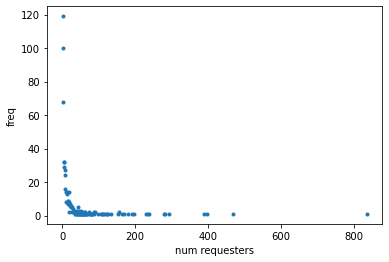

In [7]:
#Requester distribution for resources of neg examples
res_requesters_distrib(usrvidx_resvidx_tups_neg)

In [8]:
usrvidx_resvidx_tups_pos, gur2 = get_positive_entries(gur, len(usrvidx_resvidx_tups_neg), 13)
print('Num pos examples:', len(usrvidx_resvidx_tups_pos))

Num pos examples: 1152


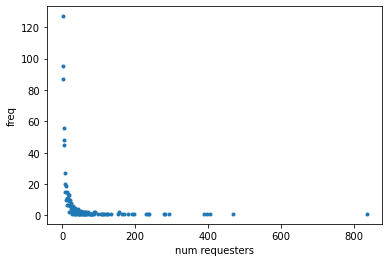

In [9]:
#Requester distribution for resources of pos examples
res_requesters_distrib(usrvidx_resvidx_tups_pos)

In [10]:
#This corresponds to nor positive non negative user-resource pairs
usrvidx_resvidx_tups_non = get_non_entries(gur, len(usrvidx_resvidx_tups_neg), 13)
print('Num non examples:', len(usrvidx_resvidx_tups_non))

Num non examples: 1152


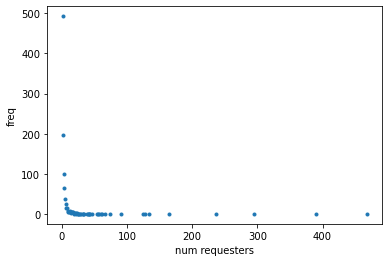

In [11]:
#Requester distribution for resources of non examples
res_requesters_distrib(usrvidx_resvidx_tups_non)

### Similarity functions

In [12]:
def commonneigh_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    uneighs2 = set()
    for resvidx in uneighs:
        uneighs2 |= set(gur.neighbors(gur.vs[resvidx]))
    rneighs = gur.neighbors(rv)
    cn = len(set(uneighs2)&set(rneighs))
    return cn

In [13]:
def jaccard_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    uneighs2 = set()
    for resvidx in uneighs:
        uneighs2 |= set(gur.neighbors(gur.vs[resvidx]))   
    rneighs = gur.neighbors(rv)
    js = len(set(uneighs2)&set(rneighs))/len(set(uneighs2)|set(rneighs))
    return js

In [14]:
def cosine_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    uneighs2 = set()
    for resvidx in uneighs:
        uneighs2 |= set(gur.neighbors(gur.vs[resvidx]))   
    rneighs = gur.neighbors(rv)
    cs = len(set(uneighs2)&set(rneighs))/math.sqrt(len(uneighs)*len(rneighs))
    return cs

In [15]:
def aa_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    uneighs2 = set()
    for resvidx in uneighs:
        uneighs2 |= set(gur.neighbors(gur.vs[resvidx])) 
    rneighs = gur.neighbors(rv)
    aasim = 0
    for usrvidx3 in list(set(uneighs2)&set(rneighs)):
        den = len(gur.neighbors(gur.vs[usrvidx3]))
        if den == 1:
            aasim += 1/100
        else:
            aasim += 1/math.log(den,10)
        
    return aasim

In [16]:
def pa_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    rneighs = gur.neighbors(rv)
    pa = len(uneighs) * len(rneighs)
    return pa

In [44]:
def compute_sims(simfunc):

    sim_neg = []
    for tup in usrvidx_resvidx_tups_neg:
        usrvidx = tup[0]
        resvidx = tup[1]
        sim = simfunc(gur, usrvidx, resvidx)
        sim_neg.append(sim)

    sim_pos = []
    for tup in usrvidx_resvidx_tups_pos:
        usrvidx = tup[0]
        resvidx = tup[1]
        sim = simfunc(gur, usrvidx, resvidx)
        sim_pos.append(sim)
        
    sim_non = []
    for tup in usrvidx_resvidx_tups_non:
        usrvidx = tup[0]
        resvidx = tup[1]
        sim = simfunc(gur, usrvidx, resvidx)
        sim_non.append(sim)
        
    return sim_pos, sim_neg, sim_non

    
def plot_simdistribs(sim_pos, sim_neg, sim_non, bins, isLog=False, shownone=True):
    plt.hist(sim_neg,bins=bins,color='tab:red')
    plt.hist(sim_pos,bins=bins,alpha=0.8,color='tab:green')
    plt.legend(['neg', 'pos'])
    if shownone:
        plt.hist(sim_non,bins=bins,alpha=0.5,color='tab:blue')
        plt.legend(['neg', 'pos', 'non'])
    if isLog:
        plt.xscale('log')
    plt.xlabel('sim')
    plt.ylabel('count')
    plt.show()

    
def _save_simvalues(sim_values, fname): 
    f = open(fname,'w')
    for sim in sim_values:
        strout = str(sim) + '\n'
        f.write(strout)
    f.close()

    
def save_simvalues(sim_pos, sim_neg, sim_non, funcname):
    _save_simvalues(sim_pos, 'dats/ch6_azkag_sim_{0}_pos.dat'.format(funcname))
    _save_simvalues(sim_neg, 'dats/ch6_azkag_sim_{0}_neg.dat'.format(funcname))
    _save_simvalues(sim_non, 'dats/ch6_azkag_sim_{0}_non.dat'.format(funcname))
    

def plot_roc_curve(sim_pos, sim_neg):
    y_true = np.array([0 for tup in usrvidx_resvidx_tups_neg] + [1 for tup in usrvidx_resvidx_tups_pos])
    y_scores = np.array([sim for sim in sim_neg] + [sim for sim in sim_pos])
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    
def auc_score(sim_pos, sim_neg):
    y_true = np.array([0 for tup in usrvidx_resvidx_tups_neg] + [1 for tup in usrvidx_resvidx_tups_pos])
    y_scores = np.array([sim for sim in sim_neg] + [sim for sim in sim_pos])
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    return roc_auc_score(y_true, y_scores)
    

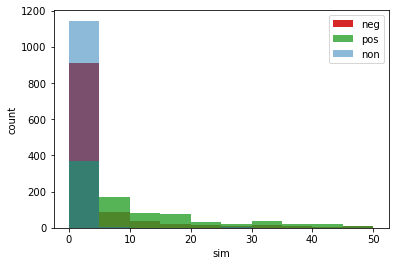

In [45]:
#Common neighbors similarity
sim_pos,sim_neg,sim_non = compute_sims(commonneigh_sim)
bins = np.linspace(0, 50, 11)
plot_simdistribs(sim_pos, sim_neg, sim_non, bins, isLog=False)
save_simvalues(sim_pos, sim_neg, sim_non, funcname='cn')

auc_cn = auc_score(sim_pos, sim_neg)

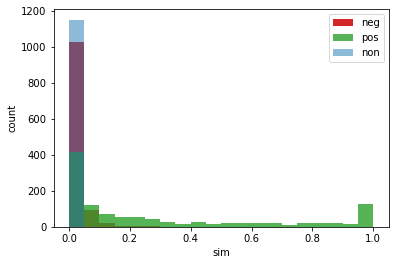

In [47]:
#Jaccard similarity
sim_pos,sim_neg,sim_non = compute_sims(jaccard_sim)
bins = np.linspace(0, 1, 21)
plot_simdistribs(sim_pos, sim_neg, sim_non, bins, isLog=False)
save_simvalues(sim_pos, sim_neg, sim_non, funcname='js')

auc_js = auc_score(sim_pos, sim_neg)

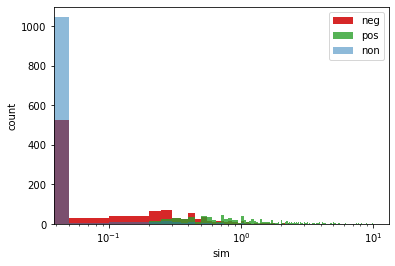

In [48]:
#Cosine similarity
sim_pos,sim_neg,sim_non = compute_sims(cosine_sim)
bins = np.linspace(0, 10, 201)
plot_simdistribs(sim_pos, sim_neg, sim_non, bins, isLog=True)
save_simvalues(sim_pos, sim_neg, sim_non, funcname='cs')

auc_cs = auc_score(sim_pos, sim_neg)

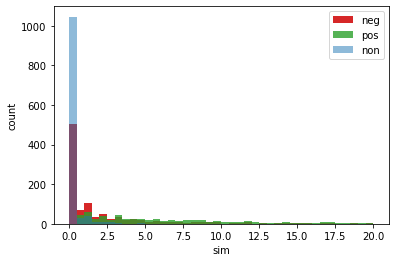

In [49]:
#Adamic-adar similarity
sim_pos,sim_neg,sim_non = compute_sims(aa_sim)
bins = np.linspace(0, 20, 41)
plot_simdistribs(sim_pos, sim_neg, sim_non, bins, isLog=False)
save_simvalues(sim_pos, sim_neg, sim_non, funcname='aa')

auc_aa = auc_score(sim_pos, sim_neg)

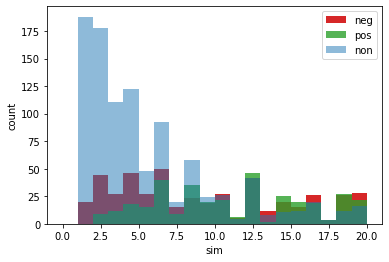

In [50]:
#Preferential attachment similarity
sim_pos,sim_neg,sim_non = compute_sims(pa_sim)
bins = np.linspace(0, 20, 21)
plot_simdistribs(sim_pos, sim_neg, sim_non, bins, isLog=False)
save_simvalues(sim_pos, sim_neg, sim_non, funcname='pa')

auc_pa = auc_score(sim_pos, sim_neg)

### ROC AUC values

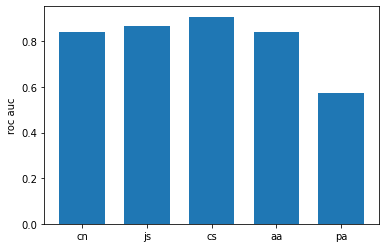

In [56]:
simlabels = ['cn','js','cs','aa','pa']
simaucs = [auc_cn, auc_js, auc_cs, auc_aa, auc_pa]

plt.bar(simlabels, simaucs, width = 0.7)
plt.ylabel('roc auc')
plt.show()

In [57]:
simaucs

[0.8392548737702547,
 0.8664441520785109,
 0.9080505371093751,
 0.8422678252797068,
 0.574029239607446]